In [1]:
import json
import bz2
import sys
import os
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as community
from chart_studio import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

defining plotting function (bad):

In [2]:
def plotly_graph(g,L,labels,colormap='grey'):
    Xv=[L[k][0] for k in list(g.nodes())]
    Yv=[L[k][1] for k in list(g.nodes())]
    Xe=[]
    Ye=[]
    for e in g.edges():
        Xe+=[[L[e[0]][0],L[e[1]][0],None]]
        Ye+=[[L[e[0]][1],L[e[1]][1],None]]
    scatters=[]
    for i in range(len(g.edges())):
        scatters.append(go.Scatter(x=Xe[i],y=Ye[i],mode='lines',line=dict(shape='spline',width=list(nx.get_edge_attributes(g,'weight').values())[i]**.25,color='mediumaquamarine')))
    scatters.append(go.Scatter(x=Xv,y=Yv,mode='markers',
            marker=dict(
                color=colormap,
                size=15,
                line=dict(
                    color=colormap,
                    width=2
                )),
            hovertemplate=labels))
    axis=dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='',
            visible=False
            )
    layout = go.Layout(
            width=1000,
            height=1000,
            showlegend=False,
            scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
            ),
        margin=dict(
            t=100
        ),
        hovermode='closest',
        paper_bgcolor='rgba(255,255,255,255)',
        plot_bgcolor='rgba(0,0,0,0)',
            )
    fig=go.Figure(data=scatters,layout=layout)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    iplot(fig)

loading catalogue and usa policitians mentions:

In [3]:
quotes_mapped='quotebank_politicians_USA_mapped.json.bz2'
WIKI_DATA_FILTERED='filtered_politician_labeled_us_v3.json.bz2'

df_full=pd.read_json(quotes_mapped, lines=True)
catalogue_df=pd.read_json(WIKI_DATA_FILTERED, lines=True)
catalogue_df.head()

,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[Republican Party],"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",[Republican Party],"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts
2,Q11124,Stephen Breyer,male,Q30,[Stephen Gerald Breyer],[Democratic Party],[[Associate Justice of the Supreme Court of th...,Q9268,,[],None
3,Q11674,David Paterson,male,Q30,[David Alexander Paterson],[Democratic Party],"[[Governor of New York, [+2008-03-17T00:00:00Z...",,,[],New York
4,Q22201,Jim DeMint,male,Q30,"[James Warren ""Jim"" DeMint, James Warren DeMint]",[Republican Party],"[[United States representative, []], [United S...",Q178169,D000595,[],None


selecting only the main democratic and republicans parties (with more than 10 politicians in the catalogue, may need to filter more to be more exhaustive?) (for each one checked on wikipedia if "affiliated to national Democratic/Republican party"). Keeping only the first party from the catalogue parties list, not sure about this.

In [4]:
#execute only once
catalogue_df=catalogue_df.loc[catalogue_df.parties.apply(len) !=0]
catalogue_df.parties=[x[0] for x in catalogue_df.parties]
catalogue_df.loc[catalogue_df.parties == 'Minnesota Democratic–Farmer–Labor Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Iowa Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'California Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Democratic-Nonpartisan League Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Democratic Party of Oregon','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Democratic Party','parties']='Democratic Party'

catalogue_df.loc[catalogue_df.parties == 'Republican Party of Minnesota','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Republican Party of Iowa','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'California Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Oregon Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Republican Party','parties']='Republican Party'
print(f'counts of politicians in 20 most common parties  {Counter(catalogue_df.parties).most_common(20)}')
catalogue_df=catalogue_df.loc[(catalogue_df.parties =='Democratic Party') | (catalogue_df.parties =='Republican Party')] #keep only republican and democrate parties and affiliates

counts of politicians in 20 most common parties  [('Democratic Party', 8528), ('Republican Party', 8069), ('New Progressive Party', 126), ('Popular Democratic Party', 113), ('independent politician', 58), ('Libertarian Party', 36), ('Green Party of the United States', 26), ('Vermont Progressive Party', 10), ('Michigan Republican Party', 9), ('Michigan Democratic Party', 7), ('Ohio Democratic Party', 6), ('Socialist Workers Party', 6), ('Socialist Equality Party', 6), ('Workers World Party', 6), ('Socialist Party USA', 6), ('North Carolina Republican Party', 5), ('Wisconsin Progressive Party', 5), ('Independence Party of Minnesota', 5), ('Constitution Party', 5), ('Whig Party', 5)]


create men_df, dataframe of single mentions where the mentioneer and mentioned politicians are in the catalogue.:

In [5]:
df=df_full[['qids','mentions_qids','speaker']]
#df=df.loc[:500,:]
men_df=pd.DataFrame()
for i,row in df.iterrows():
    if row.qids[0] in catalogue_df.qid.values:
        for mention_qid in row.mentions_qids:
            if mention_qid in catalogue_df.qid.values:
                mention=pd.Series([row.qids[0],mention_qid,row.speaker])
                men_df=men_df.append(mention,ignore_index=True)
                if i %10000==0: print(i)
men_df.rename(columns={0:'qid',1:'mention_qid',2:'speaker'},inplace=True)
print(men_df.head())
print(f'men_df shape {men_df.shape}')

0
10000
20000
        qid mention_qid                 speaker
0    Q22686      Q22686  President Donald Trump
1  Q3957020       Q6279            Kevin Cramer
2  Q3957020     Q311269            Kevin Cramer
3     Q6279       Q6279               Joe Biden
4     Q1124       Q1124  President Bill Clinton
men_df shape (26640, 3)


create the adjacency table:

In [6]:
adj_df = pd.crosstab(men_df.qid, men_df.mention_qid)
idx = adj_df.columns.union(adj_df.index)
adj_df = adj_df.reindex(index = idx, columns=idx, fill_value=0)
adj=adj_df.values
print(f'number of politicians in network: {len(adj_df.index)}')

number of politicians in network: 1709


build graph from adjacency matrix:

In [7]:
g=nx.from_numpy_matrix(adj,create_using=nx.DiGraph)
g=nx.relabel_nodes(g,mapping=lambda x: adj_df.index[x])
L=nx.kamada_kawai_layout(g)

labels=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g.nodes()]
len(labels) #check if matches with network nodes number

1709

compute kernighan_lin_bisection of the graph. Uses only undirected graph but for communities doesn't matter. [paper link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6771089)

In [8]:
communities=community.kernighan_lin_bisection(g.to_undirected(),seed=42)
g0=g.subgraph(communities[0])
centr0=nx.degree_centrality(g0)
sorted_centr0=[x[0] for x in sorted(centr0.items(), key=lambda x: x[1], reverse=True)[:20]]

g1=g.subgraph(communities[1])
centr1=nx.degree_centrality(g1)
sorted_centr1=[x[0] for x in sorted(centr1.items(), key=lambda x: x[1], reverse=True)[:20]]

sorted_centers=[]
sorted_centers.extend(sorted_centr0)
sorted_centers.extend(sorted_centr1)
g_centr_parts=g.subgraph(sorted_centers)
Laycentr=nx.kamada_kawai_layout(g_centr_parts)
labels_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g_centr_parts.nodes()]

colors=['blue','red']
colmap_centr=['black']*nx.number_of_nodes(g_centr_parts)
counter=0
for i,n in enumerate(sorted_centr0):
    colmap_centr[i]=colors[0]
for i,n in enumerate(sorted_centr1):
    colmap_centr[i+len(sorted_centr0)]=colors[1]

plotting 20 most central nodes of each communities together:

In [9]:
plotly_graph(g_centr_parts,Laycentr,labels_centr,colmap_centr)

In [10]:
colmap=['black']*nx.number_of_nodes(g)
counter=0

for i,n in enumerate(communities[0]):
    colmap[i]=colors[0]
for i,n in enumerate(communities[1]):
    colmap[i+len(communities[0])]=colors[1]

plotting the whole graph (no sense really)

In [11]:
plotly_graph(g,L,labels,colmap)

most central nodes and nodes degree plots:

C:\Users\totol\anaconda3\envs\ADA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'count')

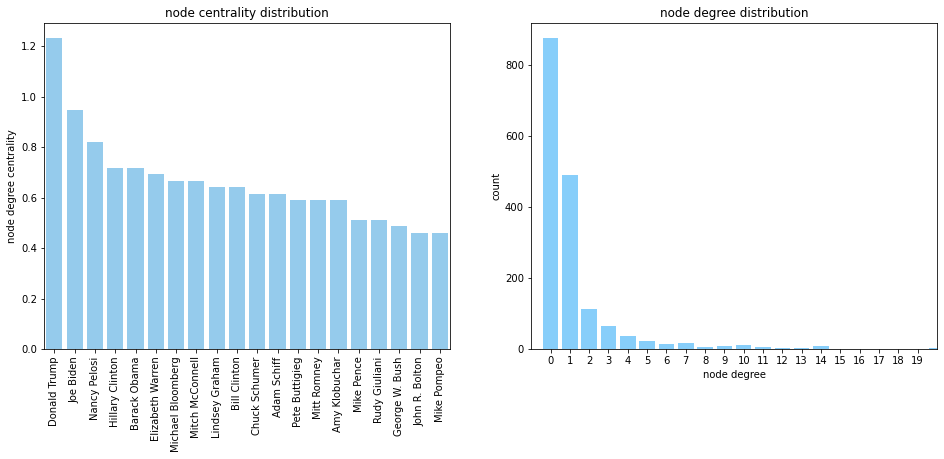

In [12]:
in_degrees = dict(g.in_degree())
in_values = sorted(in_degrees.values())
in_hist = Counter(in_degrees.values())

centr=nx.degree_centrality(g_centr_parts)
sorted_centr=sorted(centr.items(), key=lambda x: x[1], reverse=True)[:20]
names=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in [x[0] for x in sorted_centr]]

fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].set_title('node centrality distribution')
sns.barplot(names,[x[1] for x in sorted_centr], color='LightSkyBlue',ax=axs[0])
axs[0].tick_params('x',labelrotation = 90)
axs[0].set_ylabel('node degree centrality')

axs[1].set_title('node degree distribution')
axs[1].bar([x for x in in_hist], [in_hist[x] for x in in_hist], color='LightSkyBlue')
axs[1].set_xlabel('node degree')
axs[1].xaxis.set_ticks(range(20))
axs[1].set_xlim(-1,20)
axs[1].set_ylabel('count')

compute catalogue keeping only qids in network, and setting binary_party and binary_community columns:

In [13]:
catalogue_graph=catalogue_df.loc[catalogue_df.qid.isin(list(g.nodes))].copy()
catalogue_graph.reset_index(drop=True, inplace=True)
catalogue_graph['binary_party'] = np.where(catalogue_graph.parties.loc[:] == 'Democratic Party',1,0)
catalogue_graph['binary_community'] = np.where(catalogue_graph.qid.isin(list(g0.nodes)),1,0)
catalogue_graph.head()

,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State,binary_party,binary_community
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",Republican Party,"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas,0,1
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",Republican Party,"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts,0,1
2,Q22290,Olympia Snowe,female,Q30,"[Olympia J. Snowe, Olympia Bouchles, Olympia J...",Republican Party,"[[United States representative, [+1979-01-03T0...",Q3333484,S000663,[],None,0,1
3,Q23685,Jimmy Carter,male,Q30,"[James Earl Carter Jr., James E. Carter, James...",Democratic Party,"[[President of the United States, [+1977-01-20...",Q93191,,"[1976 United States presidential election, 197...",Georgia,1,1
4,Q25483,Todd Young,male,Q30,"[Todd Christopher Young, Senator Todd Young, S...",Republican Party,"[[United States representative, [+2011-01-03T0...",Q23540,Y000064,[],None,0,1


compute Spearman correlation coefficient and pval. Spearman correlation makes sense here because we want to capture if the 2 variables are correlated or anti-correlated, because we don't control wether which binary value will be applied to which community (all same => Spearman coeff=1, all contrary => Spearman coeff=-1 and we take the absolute value). We don't want to just check similarity because it doesn't capture anti-correlation. [wikipedia link](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

In [14]:
spearman_corr,spearman_pval=spearmanr(catalogue_graph.binary_party,catalogue_graph.binary_community)
abs_spearman_corr = np.abs(spearman_corr)
print(f'absolute value of Spearman correlation coefficient = {round(abs_spearman_corr,4)}, with a p-value of {round(spearman_pval,4)}')
if spearman_pval > .05:
    print(f'spearman correlation of coefficient = {round(spearman_pval,4)} > 0.05, so there is no statististically significant correlation between the two network communities and real politicians parties.')

absolute value of Spearman correlation coefficient = 0.0218, with a p-value of 0.3682
spearman correlation of coefficient = 0.3682 > 0.05, so there is no statististically significant correlation between the two network communities and real politicians parties.
